In [5]:
include("spatialSystemFunctions.jl");
using CSV
using DataFrames

  Activating project at `~/Documents/EMRE Julia Package`


# Generate Data #

In [ ]:
@species G M R P g
@parameters k₁ k₂ k₃ k₄ k₅ k₆
@variables t

# k1Vals = 10 .^(LinRange(-3, 3, 20));
k2Vals = 10 .^(LinRange(-3, 3, 20)); 
# k3Vals = 10 .^(LinRange(-3, 3, 20));
k4Vals = 10 .^(LinRange(-3, 3, 20));
# k6Vals = 10 .^(LinRange(-3, 0, 20));

k1 = 10
# k2 = 1
k3 = 1
# k4 = 1
## k5 (mRNA decay) set to 1 
k6 = 0.5

combos = collect(Iterators.product(k2Vals, k4Vals));

# REmeasureMList = zeros(length(combos));
# REmeasurePList = zeros(length(combos));
# MSEmeasureMList = zeros(length(combos));
# MSEmeasurePList = zeros(length(combos));

resultM = zeros(length(combos));
resultP = zeros(length(combos));

percentChangeM = zeros(length(combos));
percentChangeP = zeros(length(combos));

mLess1Plus50 = zeros(length(combos));

k3POverk4 = zeros(length(combos));

SSAm = zeros(length(combos));
SSAp = zeros(length(combos));

reG = zeros(length(combos))
reg = zeros(length(combos))
reM = zeros(length(combos))
reR = zeros(length(combos))
reP = zeros(length(combos))

emreM = zeros(length(combos))
emreP = zeros(length(combos))

varM = zeros(length(combos))
varP = zeros(length(combos))

covGP = zeros(length(combos))

flux1 = zeros(length(combos))
flux2 = zeros(length(combos))
flux3 = zeros(length(combos))
flux4 = zeros(length(combos))
flux5 = zeros(length(combos))
flux6 = zeros(length(combos))

j = 1;
for (k2, k4) in combos
    println(j)
    sys = SpatialSystem(sysSpecies = [
                        VoxelSpecies(G, [1], [1]),
                        VoxelSpecies(g, [1], [0]),
                        VoxelSpecies(M, [1, 2, 3, 4, 5, 6], [0, 0, 0, 0, 0, 0]),
                        VoxelSpecies(R, [3], [1]),
                        VoxelSpecies(P, [1, 2, 3, 4, 5, 6], [0, 0, 0, 0, 0, 0])
                                ],
                    sysReactions = [
                        VoxelReaction((@reaction k₁, G --> G + M), [1], [k1]),
                        VoxelReaction((@reaction k₂, M + R --> M + R + P), [3], [k2]),
                        VoxelReaction((@reaction k₃, P + G --> g), [1], [k3]),
                        VoxelReaction((@reaction k₄, P + G <-- g), [1], [k4]),
                        VoxelReaction((@reaction k₅, M --> 0), [1, 2, 3, 4, 5, 6], [1]),
                        VoxelReaction((@reaction k₆, P --> 0), [1, 2, 3, 4, 5, 6], [k6])
                                ],
                    sysDiffReactions = [
                        DiffReaction(M, [[1, 2, false], [1, 6, false], [2, 3, true], [3, 4, true], [4, 5, true], [5, 6, true]], [0.3]),
                        DiffReaction(P, [[1, 2, true], [1, 6, true], [2, 3, true], [3, 4, true], [4, 5, true], [5, 6, true]], [0.3])
                                ],
                    numVoxels = 6);

    tEnd = 400; numSteps = 201; numTrajs = 1000;
    volume = 1/(sys.numVoxels);

    rn, ics, params = getSysICsParams(sys);

    ## EMRE with no SSA
    LNAparams, SSAparams = setParams(rn, params, volume)
    timePoints, SSAmeans = runSSA(rn, ics, SSAparams, volume, tEnd, numSteps, numTrajs)
    meanIdxs, varIdxs, LNAsol = runLNA(rn, ics, LNAparams, volume, tEnd, numSteps)
    SS, realizedSS = getRealizedVector(rn, ics, LNAparams, meanIdxs, varIdxs, LNAsol, volume)
    

    # MSEm = 0;
    # MSEp = 0;
    reSumM = 0;
    emreSumM = 0;
    SSAsumM = zeros(numSteps);
    reSumP = 0;
    emreSumP = 0;
    SSAsumP = zeros(numSteps);
    # ## M species indices: 3,4,5,6,7,8
    # ## P species indices: 10,11,12,13,14,15
    for i in [3, 4, 5, 6, 7, 8]
    #     MSEm += (SS[i] - realizedSS[i])^2
        reSumM += SS[i] # sum of just RE vals from each voxel
        emreSumM += realizedSS[i] # sum of just EMRE vals from each voxel
        SSAsumM += SSAmeans[i,:]
    end;
    for i in [10, 11, 12, 13, 14, 15]
    #     MSEp += (SS[i] - realizedSS[i])^2
        reSumP += SS[i];
        emreSumP += realizedSS[i];
        SSAsumP += SSAmeans[i,:]
    end;




    ## if params don't cause any concentrations to be negative
    if all(>=(0), realizedSS)
        # REmeasureMList[j] = abs(emreSumM - reSumM)/emreSumM;
        # REmeasurePList[j] = abs(emreSumP - reSumP)/emreSumP;
        # MSEmeasureMList[j] = MSEm;
        # MSEmeasurePList[j] = MSEp;

        # direction of change
        if emreSumM == reSumM
            resultM[j] = 2;
        elseif emreSumM > reSumM
            resultM[j] = 1;
        else
            resultM[j] = 0;
        end;

        if emreSumP == reSumP
            resultP[j] = 2;
        elseif emreSumP > reSumP
            resultP[j] = 1;
        else
            resultP[j] = 0;
        end;



        # RE
        reG[j] = SS[1]
        reg[j] = SS[2]
        reM[j] = reSumM
        reR[j] = SS[9]
        reP[j] = reSumP
        # EMRE
        emreM[j] = emreSumM
        emreP[j] = emreSumP



        # var
        ## species 3 is M1
        varM[j] = LNAsol[varIdxs[3]] + 2*sum(LNAsol[varIdxs[3] + 1:varIdxs[3] + 5]) + LNAsol[varIdxs[4]] + 2*sum(LNAsol[varIdxs[4] + 1:varIdxs[4] + 4]) + LNAsol[varIdxs[5]] + 2*sum(LNAsol[varIdxs[5] + 1:varIdxs[5] + 3]) + LNAsol[varIdxs[6]] + 2*sum(LNAsol[varIdxs[6] + 1:varIdxs[6] + 2]) + LNAsol[varIdxs[7]] + 2*LNAsol[varIdxs[7] + 1]+ LNAsol[varIdxs[8]]
        # species 10 is P1
        varP[j] = LNAsol[varIdxs[10]] + 2*sum(LNAsol[varIdxs[10] + 1:varIdxs[10] + 5]) + LNAsol[varIdxs[11]] + 2*sum(LNAsol[varIdxs[11] + 1:varIdxs[11] + 4]) + LNAsol[varIdxs[12]] + 2*sum(LNAsol[varIdxs[12] + 1:varIdxs[12] + 3]) + LNAsol[varIdxs[13]] + 2*sum(LNAsol[varIdxs[13] + 1:varIdxs[13] + 2]) + LNAsol[varIdxs[14]] + 2*LNAsol[varIdxs[14] + 1]+ LNAsol[varIdxs[15]]

        # cov(G,P) 
        Gidx = varIdxs[1]
        covGP[j] = LNAsol[Gidx + 9] # just using cov with gene in the nucleus #+ LNAsol[Gidx + 10] + LNAsol[Gidx + 11] + LNAsol[Gidx + 12] + LNAsol[Gidx + 13] + LNAsol[Gidx + 14]
        
        ## if less than 2 mRNA or P
        if reSumM*volume < 2 || reSumP*volume < 2
            mLess1Plus50[j] = -1;
        elseif reSumM*volume > 50
            mLess1Plus50[j] = 1;
        end;


        # percent change
        percentChangeM[j] = abs(emreSumM - reSumM)/reSumM;
        percentChangeP[j] = abs(emreSumP - reSumP)/reSumP;


        # fluxes
        flux1[j] = k1*reG[j]
        flux2[j] = (k2/volume)*(LNAsol[varIdxs[5]+4] + SS[5]*SS[9])
        flux3[j] = (k3/volume)*(LNAsol[varIdxs[1]+9] + SS[1]*SS[10])
        flux4[j] = k4*reg[j]
        flux5[j] = 1*reM[j]
        flux6[j] = k6*reP[j]


    else
        println("Negative EMRE val");
        # REmeasureMList[j] = -1;
        # REmeasurePList[j] = -1;
        # MSEmeasureMList[j] = -1;
        # MSEmeasurePList[j] = -1;

        resultM[j] = -1;
        resultP[j] = -1;
    end;


    # bursty?
    k3POverk4[j] = (k3*reSumP)/k4;


    # # matches SSA?
    # if (((mean(SSAsumM[150:end]) < reSumM) && (emreSumM < reSumM)) || ((mean(SSAsumM[150:end]) > reSumM) && (emreSumM > reSumM)))
    #     matchesSSAm[j] = 1;
    # else
    #     matchesSSAm[j] = 0;
    # end;
    SSAm[j] = mean(SSAsumM[150:end]);
    SSAp[j] = mean(SSAsumP[150:end]);




    
    println("\tM:", emreSumM*volume, " P:", emreSumP*volume)
    j += 1;
end;

1
	M:8.66491460762587 P:0.002952875224319089
2
	M:7.434566183339873 P:0.005263482706199094
3
	M:5.4174523584251 P:0.007999534331128488
4
	M:2.7379527968222135 P:0.008474661574412293
5
	M:0.4211290369122077 P:0.0026961197952427665
6
Negative EMRE val
	M:-0.6413269551250864 P:-0.008914164007127882
7
Negative EMRE val
	M:-1.1330453182748959 P:-0.03255268083452013
8
Negative EMRE val
	M:-1.4337834271594139 P:-0.08523375296091429
9
Negative EMRE val
	M:-1.5916292770525502 P:-0.19577599871280837
10
Negative EMRE val
	M:-1.6212572517087476 P:-0.41262822749479106
11
Negative EMRE val
	M:-1.525469139050281 P:-0.8033409442933579
12
Negative EMRE val
	M:-1.2962023438002142 P:-1.4124033938253941
13
Negative EMRE val
	M:-0.9173168254626294 P:-2.0682107119229842
14
Negative EMRE val
	M:-0.3720365947392173 P:-1.7356036629076181
15
	M:0.34055140747253787 P:3.287282673025296
16
	M:1.1780793004482697 P:23.529807274557605
17
	M:2.0305381534952964 P:83.9159417230883
18
	M:2.7387862445642464 P:234.19678566

# Data Saving #

In [ ]:
# using CSV;
# using DataFrames;

paramString = "k2vk4_justG1cov"

CSV.write(string("paramSearchResultFiles/",paramString,"/reM.csv"), DataFrame(x=reM), headter = false);
CSV.write(string("paramSearchResultFiles/",paramString,"/reP.csv"), DataFrame(x=reP), headter = false);
CSV.write(string("paramSearchResultFiles/",paramString,"/reG.csv"), DataFrame(x=reG), headter = false);
CSV.write(string("paramSearchResultFiles/",paramString,"/reg.csv"), DataFrame(x=reg), headter = false);
CSV.write(string("paramSearchResultFiles/",paramString,"/reR.csv"), DataFrame(x=reR), headter = false);
CSV.write(string("paramSearchResultFiles/",paramString,"/emreM.csv"), DataFrame(x=emreM), headter = false);
CSV.write(string("paramSearchResultFiles/",paramString,"/emreP.csv"), DataFrame(x=emreP), headter = false);
CSV.write(string("paramSearchResultFiles/",paramString,"/varM.csv"), DataFrame(x=varM), headter = false);
CSV.write(string("paramSearchResultFiles/",paramString,"/varP.csv"), DataFrame(x=varP), headter = false);
CSV.write(string("paramSearchResultFiles/",paramString,"/covGP.csv"), DataFrame(x=covGP), headter = false);
CSV.write(string("paramSearchResultFiles/",paramString,"/percentChangeM.csv"), DataFrame(x=percentChangeM), headter = false);
CSV.write(string("paramSearchResultFiles/",paramString,"/percentChangeP.csv"), DataFrame(x=percentChangeP), headter = false);
CSV.write(string("paramSearchResultFiles/",paramString,"/k3POverk4.csv"), DataFrame(x=k3POverk4), headter = false);
CSV.write(string("paramSearchResultFiles/",paramString,"/SSAm.csv"), DataFrame(x=SSAm), headter = false);
CSV.write(string("paramSearchResultFiles/",paramString,"/SSAp.csv"), DataFrame(x=SSAp), headter = false);
CSV.write(string("paramSearchResultFiles/",paramString,"/k1.csv"), DataFrame(x=k1Vals), headter = false);
CSV.write(string("paramSearchResultFiles/",paramString,"/k3.csv"), DataFrame(x=k3Vals), headter = false);
CSV.write(string("paramSearchResultFiles/",paramString,"/resultM.csv"), DataFrame(x=resultM), headter = false);
CSV.write(string("paramSearchResultFiles/",paramString,"/resultP.csv"), DataFrame(x=resultP), headter = false);


# Heat Map Plotting #

In [19]:
blues = ["lightsteelblue2", "lightsteelblue3", "lightsteelblue4"];
greens = ["darkseagreen2", "darkseagreen", "darkseagreen4"];

volume = 1/6;

plt = plot(size=(1500,800), title="mRNA", titlefontsize=20, xlabel="log10(k1)", ylabel="log10(k2)", guidefontsize=20, margin=10Plots.mm, tickfontsize=10, xlims=(-3.5, 3.5), ylims=(-3.5, 3.5),
    legend=:outertopright, legendfontsize = 15);
scatter!(plt, [-10],[-10], markershape = :circle, markercolor = "white", markerstrokecolor = "black", label = "1 < mRNA, 1 < P", markersize = 10)
scatter!(plt, [-10],[-10], markershape = :dtriangle, markercolor = "white", markerstrokecolor = "black", label = "mRNA < 1 or P < 1", markersize = 10)
# scatter!(plt, [-10],[-10], markershape = :utriangle, markercolor = "white", markerstrokecolor = "black", label = "mRNA > 50", markersize = 10)
scatter!(plt, [-10],[-10], markershape = :square, markercolor = "black", markerstrokecolor = "black", label = "Negative EMRE", markersize = 10)
scatter!(plt, [-10],[-10], markershape = :square, markercolor = blues[1], markerstrokecolor = blues[1], label = " ", markersize = 10)
scatter!(plt, [-10],[-10], markershape = :square, markercolor = blues[2], markerstrokecolor = blues[2], label = "EMRE > RE", markersize = 10)
scatter!(plt, [-10],[-10], markershape = :square, markercolor = blues[3], markerstrokecolor = blues[3], label = " ", markersize = 10)
scatter!(plt, [-10],[-10], markershape = :square, markercolor = greens[1], markerstrokecolor = greens[1], label = " ", markersize = 10)
scatter!(plt, [-10],[-10], markershape = :square, markercolor = greens[2], markerstrokecolor = greens[2], label = "EMRE < RE", markersize = 10)
scatter!(plt, [-10],[-10], markershape = :square, markercolor = greens[3], markerstrokecolor = greens[3], label = " ", markersize = 10)
# scatter!(plt, [-10],[-10], markershape = :square, markercolor = "black", markerstrokecolor = "black", label = "EMRE > RE", markersize = 10)
# scatter!(plt, [-10],[-10], markershape = :square, markercolor = "gray", markerstrokecolor = "gray", label = "EMRE < RE", markersize = 10)
# scatter!(plt, [-10],[-10], markershape = :square, markercolor = "red", markerstrokecolor = "red", label = "Negative EMRE", markersize = 10)

j = 1;
for tuple in combos
    s  = 18
    # determine shape 
    # if mLess1Plus50[j] == 0
    #     shape = :circle
    # elseif mLess1Plus50[j] == -1
    #     shape = :dtriangle
    # elseif mLess1Plus50[j] == 1
    #     shape = :utriangle
    # end;

    if reM[j]*volume < 1 || reP[j]*volume < 1
        shape = :dtriangle
    # elseif reM[j]*volume > 50
    #     shape = :utriangle
    else
        shape = :circle
    end;

    ## determine hue
    if percentChangeM[j] < 0.05 
        hue = 1
    elseif percentChangeM[j] < 0.5
        hue = 2
    else
        hue = 3
    end;

    ## determine colour
    if resultM[j] == 1 
        colour = blues[hue]
    elseif resultM[j] == 0
        colour = greens[hue]
    elseif resultM[j] == -1
        colour = "black"
    end;
    if matchesSSAm[j] == 0 && percentChangeM[j] > 0.05
        colour = "red"
    end;

    if k3POverk4[j] <= 5
        scatter!(plt, [log10(tuple[1])], [log10(tuple[2])], markershape = shape, markercolor = colour, markerstrokecolor = colour, label = "", markersize = s)
    else
        scatter!(plt, [log10(tuple[1])], [log10(tuple[2])], markershape = shape, markercolor = colour, markerstrokecolor = "red", label = "", markersize = s)
    end;
        
    # if resultM[j] == 1
    #     if mLess1Plus50[j] == 0
    #         scatter!(plt, [log10(tuple[1])], [log10(tuple[2])], markershape = :circle, markercolor = "black", markerstrokecolor = "black", label = "", markersize = s)
    #     elseif mLess1Plus50[j] == -1
    #         scatter!(plt, [log10(tuple[1])], [log10(tuple[2])], markershape = :dtriangle, markercolor = "black", markerstrokecolor = "black", label = "", markersize = s)
    #     elseif mLess1Plus50[j] == 1
    #         scatter!(plt, [log10(tuple[1])], [log10(tuple[2])], markershape = :utriangle, markercolor = "black", markerstrokecolor = "black", label = "", markersize = s)
    #     end;
    # elseif resultM[j] == 0
    #     if mLess1Plus50[j] == 0
    #         scatter!(plt, [log10(tuple[1])], [log10(tuple[2])], markershape = :circle, markercolor = "gray", markerstrokecolor = "gray", label = "", markersize = s)
    #     elseif mLess1Plus50[j] == -1
    #         scatter!(plt, [log10(tuple[1])], [log10(tuple[2])], markershape = :dtriangle, markercolor = "gray", markerstrokecolor = "gray", label = "", markersize = s)
    #     elseif mLess1Plus50[j] == 1
    #         scatter!(plt, [log10(tuple[1])], [log10(tuple[2])], markershape = :utriangle, markercolor = "gray", markerstrokecolor = "gray", label = "", markersize = s)
    #     end;
    # elseif resultM[j] == -1
    #     if mLess1Plus50[j] == 0
    #         scatter!(plt, [log10(tuple[1])], [log10(tuple[2])], markershape = :circle, markercolor = "red", markerstrokecolor = "red", label = "", markersize = s)
    #     elseif mLess1Plus50[j] == -1
    #         scatter!(plt, [log10(tuple[1])], [log10(tuple[2])], markershape = :dtriangle, markercolor = "red", markerstrokecolor = "red", label = "", markersize = s)
    #     elseif mLess1Plus50[j] == 1
    #         scatter!(plt, [log10(tuple[1])], [log10(tuple[2])], markershape = :utriangle, markercolor = "red", markerstrokecolor = "red", label = "", markersize = s)
    #     end;
    # end;
    j += 1
end;
# Plots.savefig(plt, "paramSearchResultFiles/k1vk2/heatMap.png")
plt

UndefVarError: UndefVarError: `matchesSSAm` not defined

# Random Plots Generate & Save #

In [5]:
using Random

## need:
##      mLess1Plus50 != -1
##      resultM = 1 or 0 (up or down)
##      percentChangeM > 0.05

## indicies where mRNA & P > 10, EMRE > RE, EMRE + 5% or more from RE
indices = findall((mLess1Plus50 .!= -1) .& (resultM .== 1) .& (percentChangeM .> 0.05));

if length(indices) < 20
        subset = shuffle(indices)[1:end];
else
        subset = shuffle(indices)[1:20];
end;

for i in subset
    
    println("i: ", i)

    @species G M R P g
    @parameters k₁ k₂ k₃ k₄ k₅ k₆
    @variables t

    ## Nucleus = Voxel 1
    k1 = combos[i][1]
    k2 = 1
    k3 = combos[i][2]
    k4 = 1
    ## k5 (mRNA decay) set to 1 
    k6 = 0.5

    sys = SpatialSystem(sysSpecies = [
                            VoxelSpecies(G, [1], [1]),
                            VoxelSpecies(g, [1], [0]),
                            VoxelSpecies(M, [1, 2, 3, 4, 5, 6], [0, 0, 0, 0, 0, 0]),
                            VoxelSpecies(R, [3], [1]),
                            VoxelSpecies(P, [1, 2, 3, 4, 5, 6], [0, 0, 0, 0, 0, 0])
                                    ],
                        sysReactions = [
                            VoxelReaction((@reaction k₁, G --> G + M), [1], [k1]),
                            VoxelReaction((@reaction k₂, M + R --> M + R + P), [3], [k2]),
                            VoxelReaction((@reaction k₃, P + G --> g), [1], [k3]),
                            VoxelReaction((@reaction k₄, P + G <-- g), [1], [k4]),
                            VoxelReaction((@reaction k₅, M --> 0), [1, 2, 3, 4, 5, 6], [1]),
                            VoxelReaction((@reaction k₆, P --> 0), [1, 2, 3, 4, 5, 6], [k6])
                                    ],
                        sysDiffReactions = [
                            DiffReaction(M, [[1, 2, false], [1, 6, false], [2, 3, true], [3, 4, true], [4, 5, true], [5, 6, true]], [0.3]),
                            DiffReaction(P, [[1, 2, true], [1, 6, true], [2, 3, true], [3, 4, true], [4, 5, true], [5, 6, true]], [0.3])
                                    ],
                        numVoxels = 6);

    tEnd = 400; numSteps = 101; numTrajs = 1000;
    volume = 1/(sys.numVoxels);

    rn, ics, params = getSysICsParams(sys);
    timePoints, SSAmeans, SS, realizedSS = EMRE(rn, ics, params, volume, tEnd, numSteps, numTrajs);
    println("Done SSA")

    reSumM = 0;
    emreSumM = 0;
    SSAsumM = zeros(numSteps);
    reSumP = 0;
    emreSumP = 0;
    SSAsumP = zeros(numSteps);
    for i in [3, 4, 5, 6, 7, 8]
            reSumM += SS[i]
            emreSumM += realizedSS[i]
            SSAsumM += SSAmeans[i, :]
    end;
    for i in [10, 11, 12, 13, 14, 15]
            reSumP += SS[i];
            emreSumP += realizedSS[i];
            SSAsumP += SSAmeans[i, :]
    end;


    p = plot(timePoints, SSAsumM*volume, lw=4, label="S.S.A. mRNA", size=(1200,800), legendfontsize=20, title=string("# molecules mRNA, k1 = ",round(k1,digits=4),", k3 = ",round(k3,digits=4), ", Percent change = ", round(percentChangeM[i]*100,digits=2)), titlefontsize=20) #, ylims=(minimum(SSAsumM[25:end]*volume)-5, maximum(SSAsumM[25:end]*volume)+5))
    plot!(p, [0, tEnd], [reSumM, reSumM]*volume, lw=3, color="red", label="Deterministic mRNA")
    plot!(p, [0, tEnd], [emreSumM, emreSumM]*volume, lw=3, color="green", label="EMRE mRNA")
    println("Saving fig")
    Plots.savefig(p, string("/home/s2688039/Documents/EMRE Julia Package/SSAs from param scan/k1vk3_greq2/upplus5percent/mRNA/", i, ".png"))

    println("Saving fig")

    p = plot(timePoints, SSAsumP*volume, lw=4, label="S.S.A. Protein", size=(1200,800), legendfontsize=20, title=string("# molecules P, k1 = ",round(k1,digits=4),", k3 = ",round(k3,digits=4), ", Percent change = ", round(percentChangeP[i]*100,digits=2)), titlefontsize=20) #, ylims=(minimum(SSAsumM[25:end]*volume)-5, maximum(SSAsumM[25:end]*volume)+5))
    plot!(p, [0, tEnd], [reSumP, reSumP]*volume, lw=3, color="red", label="Deterministic P")
    plot!(p, [0, tEnd], [emreSumP, emreSumP]*volume, lw=3, color="green", label="EMRE P")
    println("Saving fig")
    Plots.savefig(p, string("/home/s2688039/Documents/EMRE Julia Package/SSAs from param scan/k1vk3_greq2/upplus5percent/Protein/", i, ".png"))
end;

i: 239
Done SSA
Saving fig
Saving fig
Saving fig
i: 179
Done SSA
Saving fig
Saving fig
Saving fig
i: 220
Done SSA
Saving fig
Saving fig
Saving fig
i: 219
Done SSA
Saving fig
Saving fig
Saving fig
i: 257
Done SSA
Saving fig
Saving fig
Saving fig
i: 298
Done SSA
Saving fig
Saving fig
Saving fig
i: 299
Done SSA
Saving fig
Saving fig
Saving fig
i: 215
Done SSA
Saving fig
Saving fig
Saving fig
i: 258
Done SSA
Saving fig
Saving fig
Saving fig
i: 256
Done SSA
Saving fig
Saving fig
Saving fig
i: 235
Done SSA
Saving fig
Saving fig
Saving fig
i: 196
Done SSA
Saving fig
Saving fig
Saving fig
i: 238
Done SSA
Saving fig
Saving fig
Saving fig
i: 319
Done SSA
Saving fig
Saving fig
Saving fig
i: 279
Done SSA
Saving fig
Saving fig
Saving fig
i: 318
Done SSA
Saving fig
Saving fig
Saving fig
i: 218
Done SSA
Saving fig
Saving fig
Saving fig
i: 280
Done SSA
Saving fig
Saving fig
Saving fig
i: 278
Done SSA
Saving fig
Saving fig
Saving fig
i: 339
Done SSA
Saving fig
Saving fig
Saving fig


# Simulate #

In [6]:
@species G M R P g
@parameters k₁ k₂ k₃ k₄ k₅ k₆
@variables t

## Nucleus = Voxel 1
k1 = 10^(1) #10^(2.2) 
k2 = 10^(0.2)
k3 = 10^(0) #10^(0.78)
k4 = 10^(-0.2)
## k5 (mRNA decay) set to 1 
k6 = 0.5

sys = SpatialSystem(sysSpecies = [
                        VoxelSpecies(G, [1], [1]),
                        VoxelSpecies(g, [1], [0]),
                        VoxelSpecies(M, [1, 2, 3, 4, 5, 6], [0, 0, 0, 0, 0, 0]),
                        VoxelSpecies(R, [3], [1]),
                        VoxelSpecies(P, [1, 2, 3, 4, 5, 6], [0, 0, 0, 0, 0, 0])
                                ],
                    sysReactions = [
                        VoxelReaction((@reaction k₁, G --> G + M), [1], [k1]),
                        VoxelReaction((@reaction k₂, M + R --> M + R + P), [3], [k2]),
                        VoxelReaction((@reaction k₃, P + G --> g), [1], [k3]),
                        VoxelReaction((@reaction k₄, P + G <-- g), [1], [k4]),
                        VoxelReaction((@reaction k₅, M --> 0), [1, 2, 3, 4, 5, 6], [1]),
                        VoxelReaction((@reaction k₆, P --> 0), [1, 2, 3, 4, 5, 6], [k6])
                                ],
                    sysDiffReactions = [
                        DiffReaction(M, [[1, 2, false], [1, 6, false], [2, 3, true], [3, 4, true], [4, 5, true], [5, 6, true]], [0.3]),
                        DiffReaction(P, [[1, 2, true], [1, 6, true], [2, 3, true], [3, 4, true], [4, 5, true], [5, 6, true]], [0.3])
                                ],
                    numVoxels = 6);

tEnd = 400; numSteps = 101; numTrajs = 1000;
volume = 1/(sys.numVoxels);

rn, ics, params = getSysICsParams(sys);
timePoints, SSAmeans, SS, realizedSS = EMRE(rn, ics, params, volume, tEnd, numSteps, numTrajs);


reSumM = 0;
emreSumM = 0;
SSAsumM = zeros(numSteps);
reSumP = 0;
emreSumP = 0;
SSAsumP = zeros(numSteps);
for i in [3, 4, 5, 6, 7, 8]
        reSumM += SS[i]
        emreSumM += realizedSS[i]
        SSAsumM += SSAmeans[i, :]
end;
for i in [10, 11, 12, 13, 14, 15]
        reSumP += SS[i];
        emreSumP += realizedSS[i];
        SSAsumP += SSAmeans[i, :]
end;


In [7]:
# LNAparams, SSAparams = setParams(rn, params, volume)
# meanIdxs, varIdxs, LNAsol = runLNA(rn, ics, LNAparams, volume, tEnd, numSteps)
# display(rn.species)

# display(LNAsol[varIdxs[1]+9]+LNAsol[varIdxs[1]+10]+LNAsol[varIdxs[1]+11]+LNAsol[varIdxs[1]+12]+LNAsol[varIdxs[1]+13]+LNAsol[varIdxs[1]+14] + reSumP*SS[1])
# display(reSumP)
# display(SS[1])
# 2*sum(LNAsol[varIdxs[3]:varIdxs[8]]) - (LNAsol[varIdxs[3]] + LNAsol[varIdxs[4]] + LNAsol[varIdxs[5]] + LNAsol[varIdxs[6]] + LNAsol[varIdxs[7]] + LNAsol[varIdxs[8]])   
# covGP = LNAsol[Gidx + 9] + LNAsol[Gidx + 10] + LNAsol[Gidx + 11] + LNAsol[Gidx + 12] + LNAsol[Gidx + 13] + LNAsol[Gidx + 14]

RE mRNA: 4.412962033704575 EMRE mRNA: 4.815325894228738 Percent difference: 9.117772993537114
SSA last 50 mean: 4.328923076923076


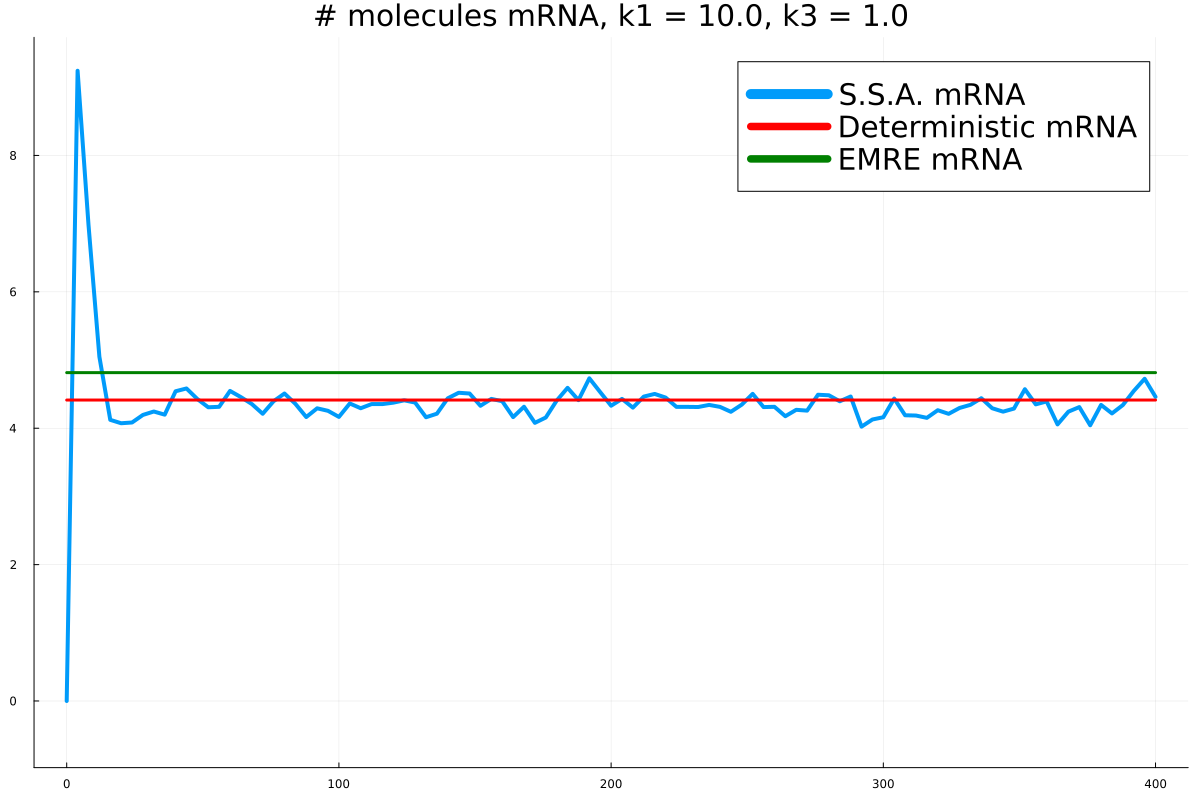

In [8]:
println("RE mRNA: ", reSumM*volume, " EMRE mRNA: ", emreSumM*volume, " Percent difference: ", abs(emreSumM - reSumM)*100/reSumM)
println("SSA last 50 mean: ", mean(SSAsumM[50:end])*volume)
plot(timePoints, SSAsumM*volume, lw=4, label="S.S.A. mRNA", size=(1200,800), legendfontsize=20, title=string("# molecules mRNA, k1 = ",round(k1,digits=4),", k3 = ",round(k3,digits=4)), titlefontsize=20, ylims=(minimum(SSAsumM[25:end]*volume)-5, maximum(SSAsumM[25:end]*volume)+5))
plot!([0, tEnd], [reSumM, reSumM]*volume, lw=3, color="red", label="Deterministic mRNA")
plot!([0, tEnd], [emreSumM, emreSumM]*volume, lw=3, color="green", label="EMRE mRNA")

RE P: 2.56054215751605 EMRE P: 2.794006578842181 Percent difference: 9.117772993537114
SSA last 50 mean: 2.567038461538462


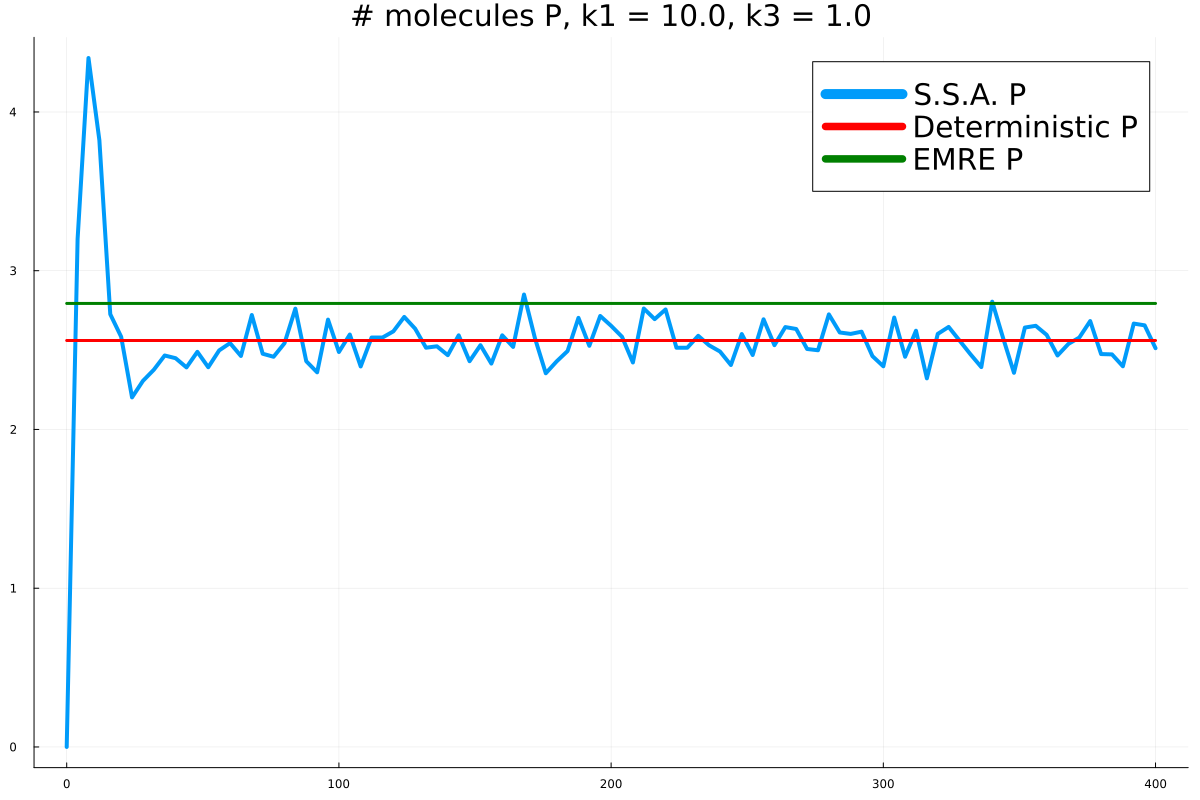

In [9]:
println("RE P: ", reSumP*volume, " EMRE P: ", emreSumP*volume, " Percent difference: ", abs(emreSumP - reSumP)*100/reSumP)
println("SSA last 50 mean: ", mean(SSAsumP[50:end])*volume)
plot(timePoints, SSAsumP*volume, lw=4, label="S.S.A. P", size=(1200,800), legendfontsize=20, title=string("# molecules P, k1 = ",round(k1,digits=4),", k3 = ",round(k3,digits=4)), titlefontsize=20)#, ylims=(minimum(SSAsumM[25:end]*volume)-5, maximum(SSAsumM[25:end]*volume)+5))
plot!([0, tEnd], [reSumP, reSumP]*volume, lw=3, color="red", label="Deterministic P")
plot!([0, tEnd], [emreSumP, emreSumP]*volume, lw=3, color="green", label="EMRE P")

# One Voxel #

In [38]:
@species G M R P g
@parameters k₁ k₂ k₃ k₄ k₅ k₆
@variables t

k1Vals = 10 .^(LinRange(-3, 3, 20));
# k2Vals = 10 .^(LinRange(-3, 3, 20)); 
k3Vals = 10 .^(LinRange(-3, 3, 20));
# k4Vals = 10 .^(LinRange(-3, 3, 20));
# k6Vals = 10 .^(LinRange(-3, 0, 20));

# k1 = 100
k2 = 1
# k3 = 1
k4 = 1
## k5 (mRNA decay) set to 1 
k6 = 0.5

combos = collect(Iterators.product(k1Vals, k3Vals));

# REmeasureMList = zeros(length(combos));
# REmeasurePList = zeros(length(combos));
# MSEmeasureMList = zeros(length(combos));
# MSEmeasurePList = zeros(length(combos));

resultM = zeros(length(combos));
resultP = zeros(length(combos));

percentChangeM = zeros(length(combos));
percentChangeP = zeros(length(combos));

mLess1Plus50 = zeros(length(combos));

k3POverk4 = zeros(length(combos));

matchesSSAm = zeros(length(combos));

reM = zeros(length(combos))
reP = zeros(length(combos))

emreM = zeros(length(combos))
emreP = zeros(length(combos))

stdM = zeros(length(combos))
stdP = zeros(length(combos))

cvP = zeros(length(combos))
cvM = zeros(length(combos))

j = 1;
for (k1, k3) in combos
    println(j)
    sys = SpatialSystem(sysSpecies = [
                        VoxelSpecies(G, [1], [1]),
                        VoxelSpecies(g, [1], [0]),
                        VoxelSpecies(M, [1], [0]),
                        VoxelSpecies(R, [1], [1]),
                        VoxelSpecies(P, [1], [0])
                                ],
                    sysReactions = [
                        VoxelReaction((@reaction k₁, G --> G + M), [1], [k1]),
                        VoxelReaction((@reaction k₂, M + R --> M + R + P), [1], [k2]),
                        VoxelReaction((@reaction k₃, P + G --> g), [1], [k3]),
                        VoxelReaction((@reaction k₄, P + G <-- g), [1], [k4]),
                        VoxelReaction((@reaction k₅, M --> 0), [1], [1]),
                        VoxelReaction((@reaction k₆, P --> 0), [1], [k6])
                                ],
                    sysDiffReactions = [],
                    numVoxels = 1);

    tEnd = 400; numSteps = 201; numTrajs = 1000;
    volume = 1/(sys.numVoxels);

    rn, ics, params = getSysICsParams(sys);

    ## EMRE with no SSA
    LNAparams, SSAparams = setParams(rn, params, volume)
    timePoints, SSAmeans = runSSA(rn, ics, SSAparams, volume, tEnd, numSteps, numTrajs)
    meanIdxs, varIdxs, LNAsol = runLNA(rn, ics, LNAparams, volume, tEnd, numSteps)
    SS, realizedSS = getRealizedVector(rn, ics, LNAparams, meanIdxs, varIdxs, LNAsol, volume)
    

    # MSEm = 0;
    # MSEp = 0;
    reSumM = 0;
    emreSumM = 0;
    SSAsumM = zeros(numSteps);
    reSumP = 0;
    emreSumP = 0;
    SSAsumP = zeros(numSteps);
    
    for i in [3]
    #     MSEm += (SS[i] - realizedSS[i])^2
        reSumM += SS[i] # sum of just RE vals from each voxel
        emreSumM += realizedSS[i] # sum of just EMRE vals from each voxel
        SSAsumM += SSAmeans[i,:]
    end;
    for i in [5]
    #     MSEp += (SS[i] - realizedSS[i])^2
        reSumP += SS[i];
        emreSumP += realizedSS[i];
        SSAsumP += SSAmeans[i,:]
    end;




    ## if params don't cause any concentrations to be negative
    if all(>=(0), realizedSS)
        # REmeasureMList[j] = abs(emreSumM - reSumM)/emreSumM;
        # REmeasurePList[j] = abs(emreSumP - reSumP)/emreSumP;
        # MSEmeasureMList[j] = MSEm;
        # MSEmeasurePList[j] = MSEp;

        # direction of change
        if emreSumM == reSumM
            resultM[j] = 2;
        elseif emreSumM > reSumM
            resultM[j] = 1;
        else
            resultM[j] = 0;
        end;

        if emreSumP == reSumP
            resultP[j] = 2;
        elseif emreSumP > reSumP
            resultP[j] = 1;
        else
            resultP[j] = 0;
        end;



        # RE
        reM[j] = reSumM
        reP[j] = reSumP
        # EMRE
        emreM[j] = emreSumM
        emreP[j] = emreSumP



        # std 
        stdM[j] = (LNAsol[varIdxs[3]])^(1/2)
        stdP[j] = (LNAsol[varIdxs[5]])^(1/2)



        # CV
        cvM[j] = stdM[j]/reM[j]
        cvP[j] = stdP[j]/reP[j]


        
        ## if less than 2 mRNA or P
        if reSumM*volume < 2 || reSumP*volume < 2
            mLess1Plus50[j] = -1;
        elseif reSumM*volume > 50
            mLess1Plus50[j] = 1;
        end;


        # percent change
        percentChangeM[j] = abs(emreSumM - reSumM)/reSumM;
        percentChangeP[j] = abs(emreSumP - reSumP)/reSumP;

    else
        println("Negative EMRE val");
        # REmeasureMList[j] = -1;
        # REmeasurePList[j] = -1;
        # MSEmeasureMList[j] = -1;
        # MSEmeasurePList[j] = -1;

        resultM[j] = -1;
        resultP[j] = -1;
    end;


    # bursty?
    k3POverk4[j] = (k3*reSumP)/k4;


    # matches SSA?
    if (((mean(SSAsumM[150:end]) < reSumM) && (emreSumM < reSumM)) || ((mean(SSAsumM[150:end]) > reSumM) && (emreSumM > reSumM)))
        matchesSSAm[j] = 1;
    else
        matchesSSAm[j] = 0;
    end;




    
    println("\tM:", emreSumM*volume, " P:", emreSumP*volume)
    j += 1;
end;

1
	M:0.0009999980006868924 P:0.001999992023492427
2
	M:0.0020691295229678733 P:0.004138254254330827
3
	M:0.004281295759777743 P:0.008562586226158709
4
	M:0.008858511044919616 P:0.0177169968199919
5
	M:0.018329135567490343 P:0.03665820077185991
6
	M:0.03792402702063503 P:0.07584793937355917
7
	M:0.07846369047782459 P:0.15692727342983828
8
	M:0.16232500171521033 P:0.3246496562579014
9
	M:0.3357564636040243 P:0.6715129272080488
10
	M:0.6942291988928324 P:1.388458397785664
11
	M:1.4343355671640292 P:2.868671134328058
12
	M:2.958834619237227 P:5.917669238474454
13
	M:6.084338321691313 P:12.168676643382627
14
	M:12.432574676812159 P:24.865149353624318
15
	M:25.09806733220537 P:50.196134664410735
16
	M:49.57896699778473 P:99.15793399556945
17
	M:94.62773591639927 P:189.25547183279855
18
	M:172.53876242612435 P:345.07752485224864
19
	M:299.4614179014794 P:598.922835802959
20
	M:497.4323652390249 P:994.8647304780496
21
	M:0.000999995866096736 P:0.001999987656979955
22
	M:0.0020691203841438494 P

In [40]:
CSV.write("paramSearchResultFiles/oneVoxel/k1vk3/reM.csv", DataFrame(x=reM), headter = false);
CSV.write("paramSearchResultFiles/oneVoxel/k1vk3/reP.csv", DataFrame(x=reP), headter = false);
CSV.write("paramSearchResultFiles/oneVoxel/k1vk3/emreM.csv", DataFrame(x=emreM), headter = false);
CSV.write("paramSearchResultFiles/oneVoxel/k1vk3/emreP.csv", DataFrame(x=emreP), headter = false);
CSV.write("paramSearchResultFiles/oneVoxel/k1vk3/stdM.csv", DataFrame(x=stdM), headter = false);
CSV.write("paramSearchResultFiles/oneVoxel/k1vk3/stdP.csv", DataFrame(x=stdP), headter = false);
CSV.write("paramSearchResultFiles/oneVoxel/k1vk3/cvM.csv", DataFrame(x=cvM), headter = false);
CSV.write("paramSearchResultFiles/oneVoxel/k1vk3/cvP.csv", DataFrame(x=cvP), headter = false);
CSV.write("paramSearchResultFiles/oneVoxel/k1vk3/percentChangeM.csv", DataFrame(x=percentChangeM), headter = false);
CSV.write("paramSearchResultFiles/oneVoxel/k1vk3/percentChangeP.csv", DataFrame(x=percentChangeP), headter = false);
CSV.write("paramSearchResultFiles/oneVoxel/k1vk3/k3POverk4.csv", DataFrame(x=k3POverk4), headter = false);
CSV.write("paramSearchResultFiles/oneVoxel/k1vk3/matchesSSAm.csv", DataFrame(x=matchesSSAm), headter = false);
CSV.write("paramSearchResultFiles/oneVoxel/k1vk3/k1.csv", DataFrame(x=k1Vals), headter = false);
CSV.write("paramSearchResultFiles/oneVoxel/k1vk3/k3.csv", DataFrame(x=k3Vals), headter = false);
CSV.write("paramSearchResultFiles/oneVoxel/k1vk3/resultM.csv", DataFrame(x=resultM), headter = false);
CSV.write("paramSearchResultFiles/oneVoxel/k1vk3/resultP.csv", DataFrame(x=resultP), headter = false);

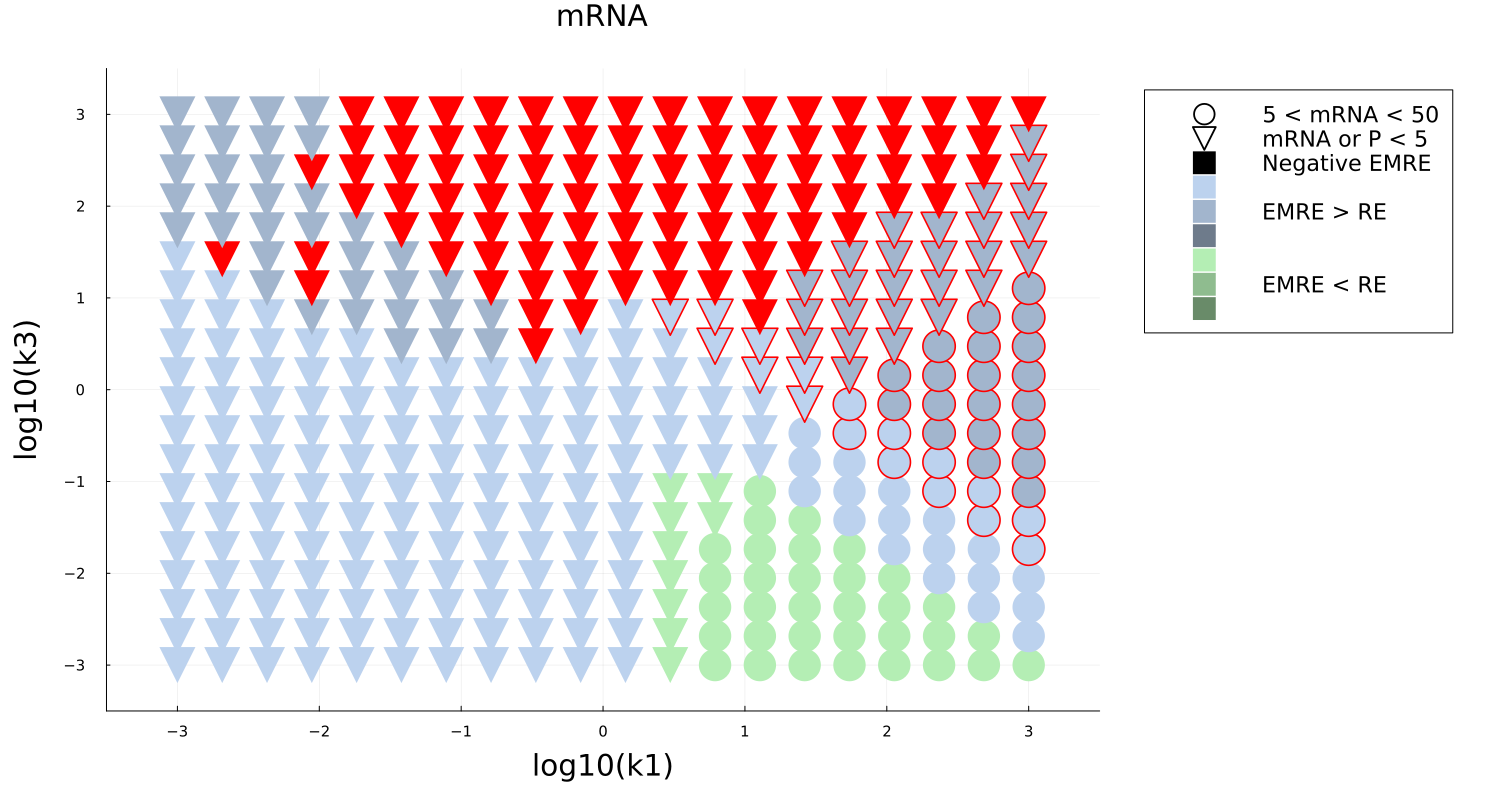

In [75]:
blues = ["lightsteelblue2", "lightsteelblue3", "lightsteelblue4"];
greens = ["darkseagreen2", "darkseagreen", "darkseagreen4"];

plt = plot(size=(1500,800), title="mRNA", titlefontsize=20, xlabel="log10(k1)", ylabel="log10(k3)", guidefontsize=20, margin=10Plots.mm, tickfontsize=10, xlims=(-3.5, 3.5), ylims=(-3.5, 3.5),
    legend=:outertopright, legendfontsize = 15);
scatter!(plt, [-10],[-10], markershape = :circle, markercolor = "white", markerstrokecolor = "black", label = "5 < mRNA < 50", markersize = 10)
scatter!(plt, [-10],[-10], markershape = :dtriangle, markercolor = "white", markerstrokecolor = "black", label = "mRNA or P < 5", markersize = 10)
# scatter!(plt, [-10],[-10], markershape = :utriangle, markercolor = "white", markerstrokecolor = "black", label = "mRNA > 50", markersize = 10)
scatter!(plt, [-10],[-10], markershape = :square, markercolor = "black", markerstrokecolor = "black", label = "Negative EMRE", markersize = 10)
scatter!(plt, [-10],[-10], markershape = :square, markercolor = blues[1], markerstrokecolor = blues[1], label = " ", markersize = 10)
scatter!(plt, [-10],[-10], markershape = :square, markercolor = blues[2], markerstrokecolor = blues[2], label = "EMRE > RE", markersize = 10)
scatter!(plt, [-10],[-10], markershape = :square, markercolor = blues[3], markerstrokecolor = blues[3], label = " ", markersize = 10)
scatter!(plt, [-10],[-10], markershape = :square, markercolor = greens[1], markerstrokecolor = greens[1], label = " ", markersize = 10)
scatter!(plt, [-10],[-10], markershape = :square, markercolor = greens[2], markerstrokecolor = greens[2], label = "EMRE < RE", markersize = 10)
scatter!(plt, [-10],[-10], markershape = :square, markercolor = greens[3], markerstrokecolor = greens[3], label = " ", markersize = 10)
# scatter!(plt, [-10],[-10], markershape = :square, markercolor = "black", markerstrokecolor = "black", label = "EMRE > RE", markersize = 10)
# scatter!(plt, [-10],[-10], markershape = :square, markercolor = "gray", markerstrokecolor = "gray", label = "EMRE < RE", markersize = 10)
# scatter!(plt, [-10],[-10], markershape = :square, markercolor = "red", markerstrokecolor = "red", label = "Negative EMRE", markersize = 10)

j = 1;
for tuple in combos
    s  = 18
    # determine shape 
    # if mLess1Plus50[j] == 0
    #     shape = :circle
    # elseif mLess1Plus50[j] == -1
    #     shape = :dtriangle
    # elseif mLess1Plus50[j] == 1
    #     shape = :utriangle
    # end;

    if reM[j]*volume < 1 || reP[j]*volume < 10
        shape = :dtriangle
    # elseif reM[j]*volume > 50
    #     shape = :utriangle
    else
        shape = :circle
    end;

    ## determine hue
    if percentChangeM[j] < 0.05 
        hue = 1
    elseif percentChangeM[j] < 0.5
        hue = 2
    else
        hue = 3
    end;

    ## determine colour
    if resultM[j] == 1 
        colour = blues[hue]
    elseif resultM[j] == 0
        colour = greens[hue]
    elseif resultM[j] == -1
        colour = "black"
    end;
    if matchesSSAm[j] == 0 && percentChangeM[j] > 0.05
        colour = "red"
    end;

    if k3POverk4[j] <= 5
        scatter!(plt, [log10(tuple[1])], [log10(tuple[2])], markershape = shape, markercolor = colour, markerstrokecolor = colour, label = "", markersize = s)
    else
        scatter!(plt, [log10(tuple[1])], [log10(tuple[2])], markershape = shape, markercolor = colour, markerstrokecolor = "red", label = "", markersize = s)
    end;
        
    # if resultM[j] == 1
    #     if mLess1Plus50[j] == 0
    #         scatter!(plt, [log10(tuple[1])], [log10(tuple[2])], markershape = :circle, markercolor = "black", markerstrokecolor = "black", label = "", markersize = s)
    #     elseif mLess1Plus50[j] == -1
    #         scatter!(plt, [log10(tuple[1])], [log10(tuple[2])], markershape = :dtriangle, markercolor = "black", markerstrokecolor = "black", label = "", markersize = s)
    #     elseif mLess1Plus50[j] == 1
    #         scatter!(plt, [log10(tuple[1])], [log10(tuple[2])], markershape = :utriangle, markercolor = "black", markerstrokecolor = "black", label = "", markersize = s)
    #     end;
    # elseif resultM[j] == 0
    #     if mLess1Plus50[j] == 0
    #         scatter!(plt, [log10(tuple[1])], [log10(tuple[2])], markershape = :circle, markercolor = "gray", markerstrokecolor = "gray", label = "", markersize = s)
    #     elseif mLess1Plus50[j] == -1
    #         scatter!(plt, [log10(tuple[1])], [log10(tuple[2])], markershape = :dtriangle, markercolor = "gray", markerstrokecolor = "gray", label = "", markersize = s)
    #     elseif mLess1Plus50[j] == 1
    #         scatter!(plt, [log10(tuple[1])], [log10(tuple[2])], markershape = :utriangle, markercolor = "gray", markerstrokecolor = "gray", label = "", markersize = s)
    #     end;
    # elseif resultM[j] == -1
    #     if mLess1Plus50[j] == 0
    #         scatter!(plt, [log10(tuple[1])], [log10(tuple[2])], markershape = :circle, markercolor = "red", markerstrokecolor = "red", label = "", markersize = s)
    #     elseif mLess1Plus50[j] == -1
    #         scatter!(plt, [log10(tuple[1])], [log10(tuple[2])], markershape = :dtriangle, markercolor = "red", markerstrokecolor = "red", label = "", markersize = s)
    #     elseif mLess1Plus50[j] == 1
    #         scatter!(plt, [log10(tuple[1])], [log10(tuple[2])], markershape = :utriangle, markercolor = "red", markerstrokecolor = "red", label = "", markersize = s)
    #     end;
    # end;
    j += 1
end;
# Plots.savefig(plt, "/home/s2688039/Documents/EMRE Julia Package/SSAs from param scan/k1vk3_greq2/heatMap.png")
plt

In [76]:
@species G M R P g
@parameters k₁ k₂ k₃ k₄ k₅ k₆
@variables t

## Nucleus = Voxel 1
k1 = 10^(2.2) 
k2 = 10^(0)
k3 = 10^(0.78)
k4 = 10^(0)
## k5 (mRNA decay) set to 1 
k6 = 0.5

sys = SpatialSystem(sysSpecies = [
                        VoxelSpecies(G, [1], [1]),
                        VoxelSpecies(g, [1], [0]),
                        VoxelSpecies(M, [1], [0]),
                        VoxelSpecies(R, [1], [1]),
                        VoxelSpecies(P, [1], [0])
                                ],
                    sysReactions = [
                        VoxelReaction((@reaction k₁, G --> G + M), [1], [k1]),
                        VoxelReaction((@reaction k₂, M + R --> M + R + P), [1], [k2]),
                        VoxelReaction((@reaction k₃, P + G --> g), [1], [k3]),
                        VoxelReaction((@reaction k₄, P + G <-- g), [1], [k4]),
                        VoxelReaction((@reaction k₅, M --> 0), [1], [1]),
                        VoxelReaction((@reaction k₆, P --> 0), [1], [k6])
                                ],
                    sysDiffReactions = [],
                    numVoxels = 1);

tEnd = 400; numSteps = 101; numTrajs = 1000;
volume = 1/(sys.numVoxels);

rn, ics, params = getSysICsParams(sys);
timePoints, SSAmeans, SS, realizedSS = EMRE(rn, ics, params, volume, tEnd, numSteps, numTrajs);

In [42]:
LNAparams, SSAparams = setParams(rn, params, volume)
meanIdxs, varIdxs, LNAsol = runLNA(rn, ics, LNAparams, volume, tEnd, numSteps)


UndefVarError: UndefVarError: `rn` not defined

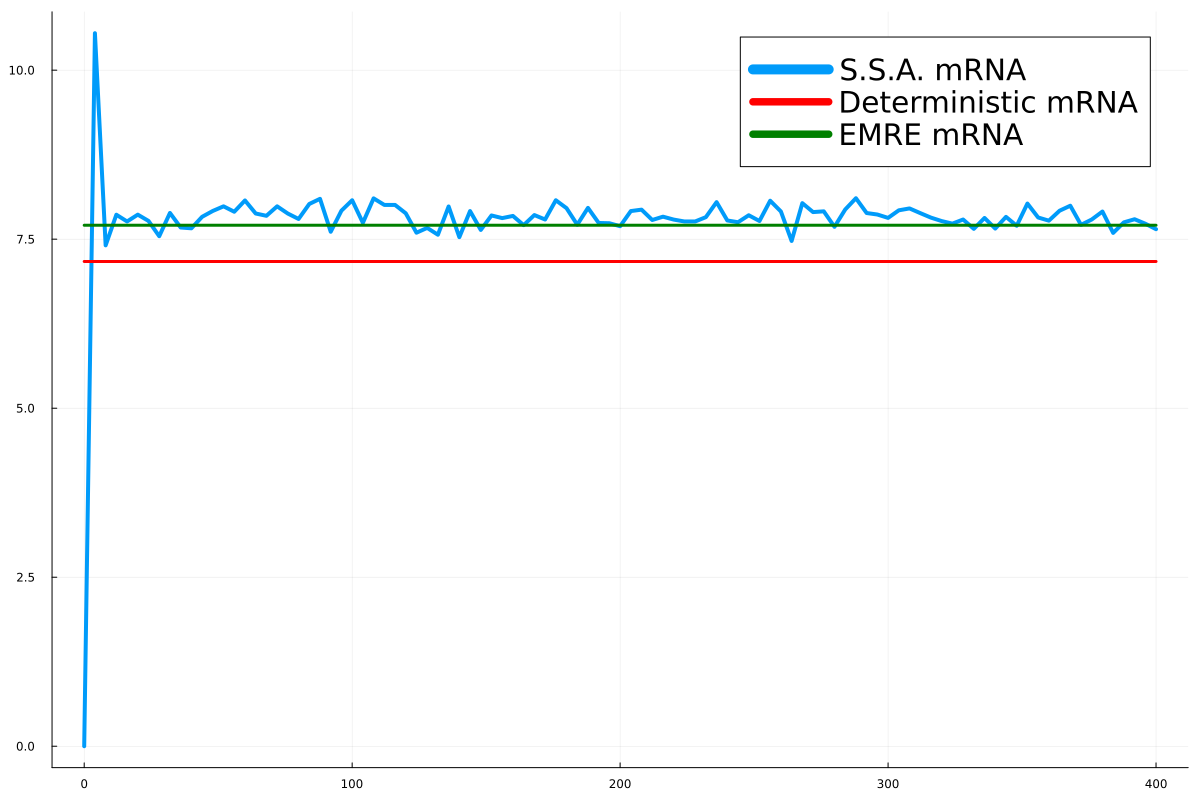

In [78]:
i = 5

plot(timePoints, SSAmeans[i,:]*volume, lw=4, label="S.S.A. mRNA", size=(1200,800), legendfontsize=20) # title=string("# molecules mRNA, k1 = ",round(k1,digits=4),", k3 = ",round(k3,digits=4)), titlefontsize=20, ylims=(minimum(SSAsumM[25:end]*volume)-5, maximum(SSAsumM[25:end]*volume)+5))
plot!([0, tEnd], [SS[i], SS[i]]*volume, lw=3, color="red", label="Deterministic mRNA")
plot!([0, tEnd], [realizedSS[i], realizedSS[i]]*volume, lw=3, color="green", label="EMRE mRNA")